In [2]:
# NumPy: 数値計算を効率的に行うためのライブラリ
import numpy as np

# Matplotlib: グラフ描画のためのライブラリ
import matplotlib.pyplot as plt

# Pandas: データ分析を容易にするためのライブラリ
import pandas as pd

# SciPy: 科学技術計算のためのライブラリ
from scipy.stats import norm  # 正規分布に関連する関数を扱うモジュール

# Scikit-learn: 機械学習のためのライブラリ
from sklearn.cross_decomposition import PLSRegression  # 部分最小二乗回帰モデルを扱うモジュール
from sklearn.metrics import mean_squared_error  # 平均二乗誤差を計算する関数


## <span style="color: DeepPink; ">部分的最小二乗回帰（PLS法）</span>

### <span style="color: blue; ">正規分布を三つ重ねる関数</span> 

In [3]:
# 3つの正規分布を合わせる関数
def make_normal(wave, d_std, d_posi, d_inten, noiselevel):
    """
    吸収スペクトルデータ（A）と既知の濃度データ（C）を使用して、検量線（K）と予測濃度（predC）を計算し、
    吸収スペクトルと検量線をプロットする関数。

    Parameters:
    wave (numpy.ndarray): 波長データ
    d_std (numpy.ndarray): 正規分布の標準偏差
    d_posi (numpy.ndarray): 正規分布の位置（平均）
    d_inten (numpy.ndarray): 各試料の各正規分布に対する強度
    noiselevel (float): ノイズレベル

    Returns:
    numpy.ndarray: 各試料の吸収スペクトルデータ
    """
    len_wave = len(wave)  # 横軸の長さ
    len_sample = len(d_inten)  # 試料数
    len_nd = len(d_std)  # 合わせる正規分布の数
    Xall = np.zeros((len_wave, len_sample))  # 行数：波長数、列数サンプル数のゼロ行列

    for i in range(len_sample):  # 各サンプルに対して
        for k in range(len_nd):  # 各正規分布に対して
            Xall[:, i] = Xall[:, i] + d_inten[i, k] * norm.pdf(wave, d_posi[k], d_std[k])
        # ノイズの追加
        Xall[:, i] = Xall[:, i] + noiselevel * np.max(Xall[:, i]) * (0.5 - np.random.randn(len_wave))

    plt.figure(figsize=(10, 6))
    plt.plot(wave, Xall)
    for k in range(len_nd):
        plt.plot(wave, norm.pdf(wave, d_posi[k], d_std[k]), 'black')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

    Xall = Xall.transpose()  # スペクトルを扱うときは行がサンプル、列が波長
    return Xall

### <span style="color: blue; ">ある程度相関のある強度を作成</span> 

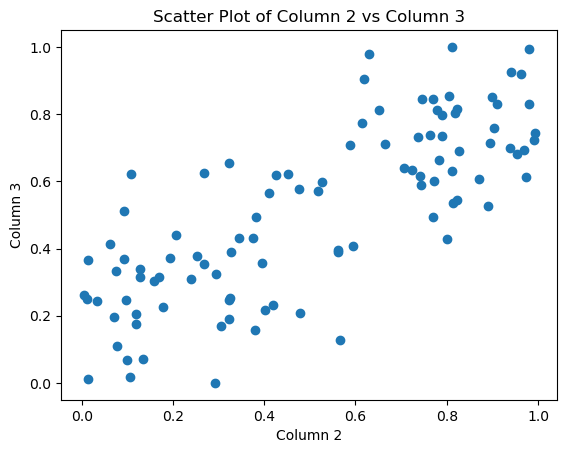

In [4]:
# 0から99までの整数値を含む配列 wave を作成
wave = np.arange(0, 100, 1)

# 標準偏差を表す配列 d_std と、位置を表す配列 d_posi を定義
d_std = np.array([7, 6, 8])
d_posi = np.array([30, 60, 80])

# 100行2列のランダムな値を含む配列 d_inten を生成
d_inten = np.random.rand(100, 2)

# d_inten の2列目のデータを用いて、新しい3列目のデータ third_column を生成
m_X = np.mean(d_inten[:, 1])
sd_X = np.std(d_inten[:, 1])
rho = 0.95
Z = np.random.randn(100)
third_column = m_X + sd_X * ((d_inten[:, 1] - m_X) / sd_X) * rho + Z * np.sqrt(1 - rho**2)

# third_column のデータを0から1の範囲に正規化
third_column = third_column - min(third_column)  # 最小値を0にシフト
third_column_scale = max(third_column)  # スケーリングのための最大値取得
third_column = third_column / third_column_scale

# d_inten に新しい third_column を追加
d_inten = np.column_stack((d_inten, third_column))

# d_inten の2列目と3列目のデータを用いて散布図を作成
plt.scatter(d_inten[:, 1], d_inten[:, 2])
plt.xlabel('Column 2')
plt.ylabel('Column 3')
plt.title('Scatter Plot of Column 2 vs Column 3')
plt.show()

### <span style="color: blue; ">スペクトルデータの作成</span> 

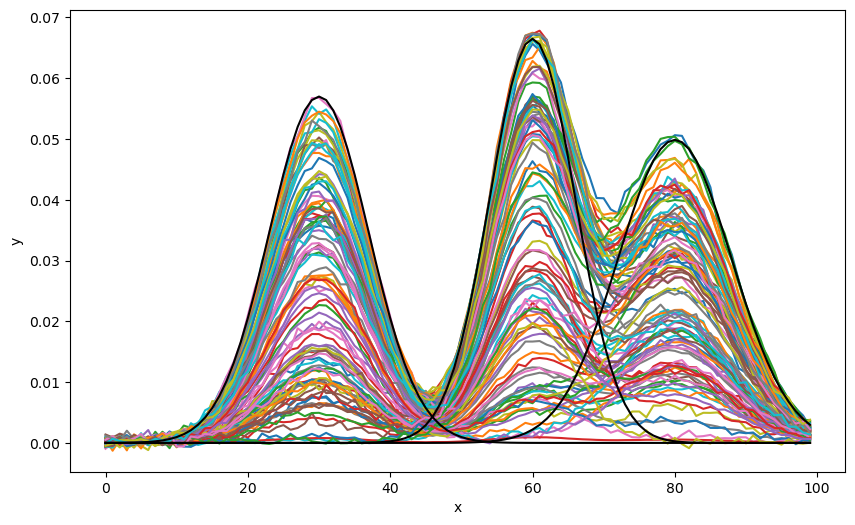

In [5]:
A=make_normal(wave,d_std,d_posi,d_inten,0.01)
C=d_inten[:,[1,2]]
row_means=C.mean(axis=0).reshape(1,- 1)
C=C-row_means
row_means = A.mean(axis=0).reshape(1,- 1)
A=A-row_means 

### <span style="color: blue; ">PLSRと再構築スペクトル等</span> 

収束演算の回数は： [3, 4, 2, 19]


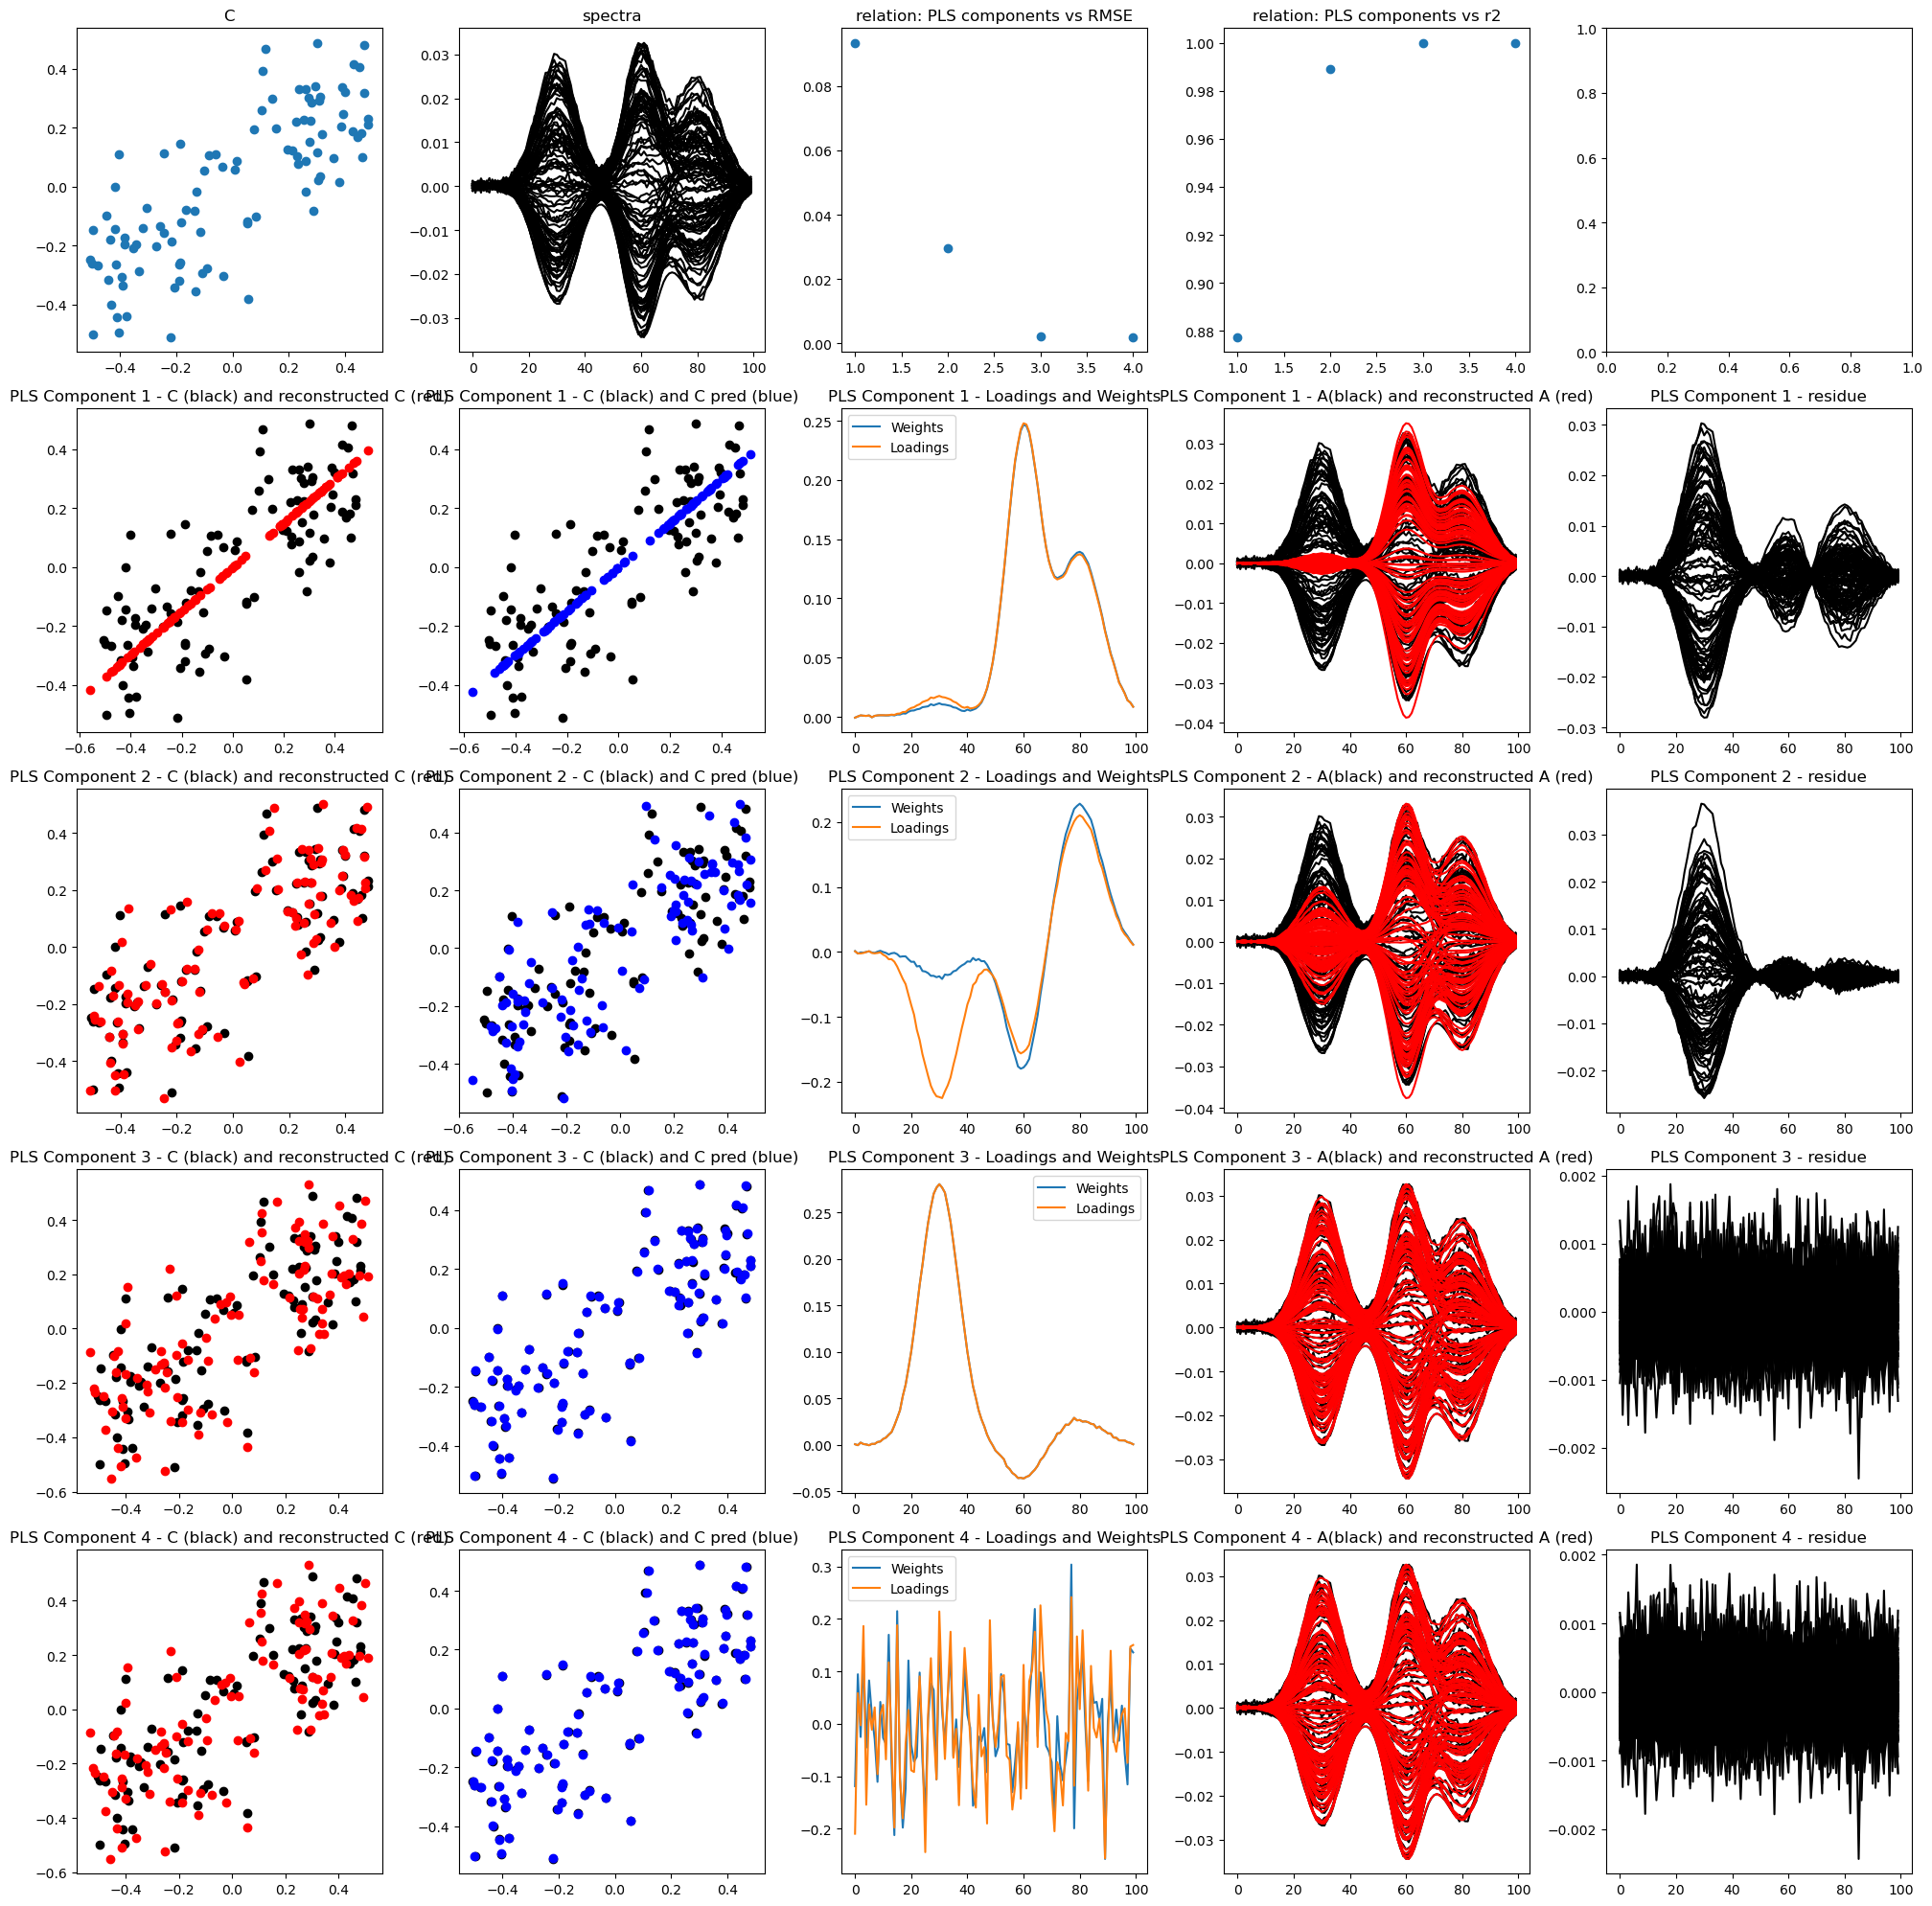

In [6]:
# 決定係数R2とRMSEを格納するためのリストを初期化
r2_scores = []
rmse_scores = []

# PLS法の成分の範囲を設定（1から4まで）
component_range = range(1, 5) 

# PLS法の成分の数に応じてループし,モデルを訓練して性能を評価
for n_c in component_range:
    pls = PLSRegression(n_components=n_c, scale=False)  # PLS回帰モデルを作成
    pls.fit(A, C)  # モデルにA（スペクトルデータ）とC（化学成分データ）を適用して学習
    C_pred = pls.predict(A)  # Aを使用してCを予測
    r2_score = pls.score(A, C)  # 決定係数R2を計算
    rmse_score = np.sqrt(mean_squared_error(C, C_pred))  # RMSEを計算
    r2_scores.append(r2_score)  # 決定係数R2をリストに追加
    rmse_scores.append(rmse_score)  # RMSEをリストに追加

# 最終的なPLS回帰モデルを作成し、学習（成分数は4に設定）
pls = PLSRegression(n_components=4, scale=False)
pls.fit(A, C)

# 収束演算の回数を表示
print("収束演算の回数は：", pls.n_iter_)

# 可視化のためのサブプロットの準備（5x5のグリッド）
fig, axs = plt.subplots(5, 5, figsize=(20, 20))

# 各サブプロットにデータをプロット
# Cの散布図
axs[0, 0].scatter(C[:,0],C[:,1])
axs[0, 0].set_title('C')

# Aのスペクトルプロット
axs[0, 1].plot(A.T, color='black')
axs[0, 1].set_title('spectra')

# 成分数とRMSEの関係を示す散布図
axs[0, 2].scatter(range(1, 5), rmse_scores)
axs[0, 2].set_title('relation: PLS components vs RMSE')

# 成分数と決定係数R2の関係を示す散布図
axs[0, 3].scatter(range(1, 5), r2_scores)
axs[0, 3].set_title('relation: PLS components vs r2')

# 各成分に対するプロットを生成
for i in range(4):
    # 濃度の散布図とローディングの方向
    xscore = pls.x_scores_[:, i]
    xloading = pls.x_loadings_[:, i]
    yloading = pls.y_loadings_[:, i]
    yconsructed = np.dot(pls.y_scores_[:, :i+1], pls.y_loadings_[:,:i+1].T)
    y_residual = C - yconsructed
    xconsructed = np.dot(pls.x_scores_[:, :i+1], pls.x_loadings_[:, :i+1].T)
    x_residual = A - xconsructed
    ypred = np.dot(pls.x_scores_[:, :i+1], pls.y_loadings_[:,:i+1].T)

    # Cの再構築と予測値の散布図
    axs[i+1, 0].scatter(C[:,0], C[:,1], color='black')
    axs[i+1, 0].scatter(yconsructed[:,0], yconsructed[:,1], color='red')
    axs[i+1, 0].set_title(f'PLS Component {i+1} - C (black) and reconstructed C (red)')

    axs[i+1, 1].scatter(C[:,0], C[:,1], color='black')
    axs[i+1, 1].scatter(ypred[:,0], ypred[:,1], color='blue')
    axs[i+1, 1].set_title(f'PLS Component {i+1} - C (black) and C pred (blue)')

    # 重みとローディングのプロット
    axs[i+1, 2].plot(pls.x_weights_[:, i], label='Weights')
    axs[i+1, 2].plot(pls.x_loadings_[:, i], label='Loadings')
    axs[i+1, 2].legend()
    axs[i+1, 2].set_title(f'PLS Component {i+1} - Loadings and Weights')

    # Aの再構築データのプロット
    axs[i+1, 3].plot(A.T, color="black")
    axs[i+1, 3].plot(xconsructed.T, color="red")
    axs[i+1, 3].set_title(f'PLS Component {i+1} - A(black) and reconstructed A (red)')

    # 残差のプロット
    axs[i+1, 4].plot(x_residual.T, color='black')
    axs[i+1, 4].set_title(f'PLS Component {i+1} - residue')

# プロットのレイアウトを調整して表示
plt.tight_layout()
plt.show()
